In [1]:
from lsst_efd_client import EfdClient
from lsst.ts import salobj

import asyncio
import numpy as np
import os, glob
import time
import ast

from astropy.io import fits
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy import stats
from scipy.optimize import curve_fit

from astropy.time import Time, TimeDelta
import pandas as pd

from scipy.interpolate import RBFInterpolator

In [2]:
scan_files = glob.glob('/home/parfa30/DATA/ScanData/*.fits')

In [3]:
scan_files = np.sort(scan_files)
print(scan_files)

['/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-15T16:15:51.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-16T17:52:42.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-16T21:08:52.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-17T15:39:14.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-20T16:17:05.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-06T23:11:28.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-07T17:39:37.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-07T23:10:33.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-12T20:59:25.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-13T20:26:00.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-14T23:36:00.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-20T00:16:19.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-21T21:32:56.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022

In [147]:
hdu = fits.open('/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-08-31T19:08:45.fits')
hdu.info()

Filename: /home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-08-31T19:08:45.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  2             1 BinTableHDU     27   1296R x 9C   [D, D, D, D, D, D, D, D, D]   


In [148]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NAME    = 'CIMACS_full_scan'                                                    
SOURCE  = 'LED     '                                                            
WAVE    = '455nm   '                                                            
EXPTIME = '1       '                                                            
X_MIN   =               1000.0                                                  
X_MAX   =               1400.0                                                  
X_STEPS =                 35.0                                                  
Y_MIN   =                550.0                                                  
Y_MAX   =                950

In [149]:
elec_2 = hdu['2'].data

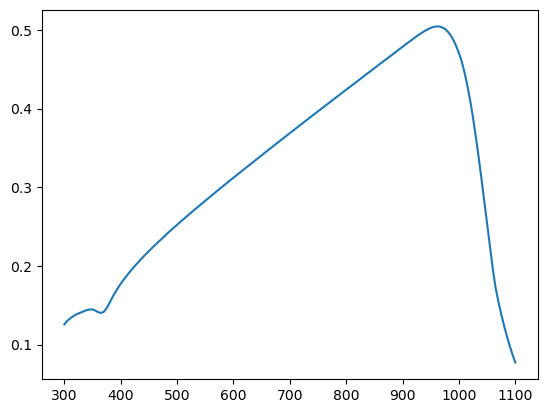

In [110]:
df = pd.read_csv('../hamamatsu_responsivity.csv')
plt.plot(df.wavelength, df.responsivity)

f = interpolate.interp1d(list(df.wavelength), list(df.responsivity))
def watts_per_mm2(amps,wl):
    area = 10**2 #10mm^2
    watts = amps/f(wl)
    watts_per_mm2 = watts/area
    return watts_per_mm2
def watts_per_cm2(amps,wl):
    print(f(wl))
    area = 1**2 #10mm^2
    watts = amps/f(wl)
    watts_per_mm2 = watts/area
    return watts_per_mm2

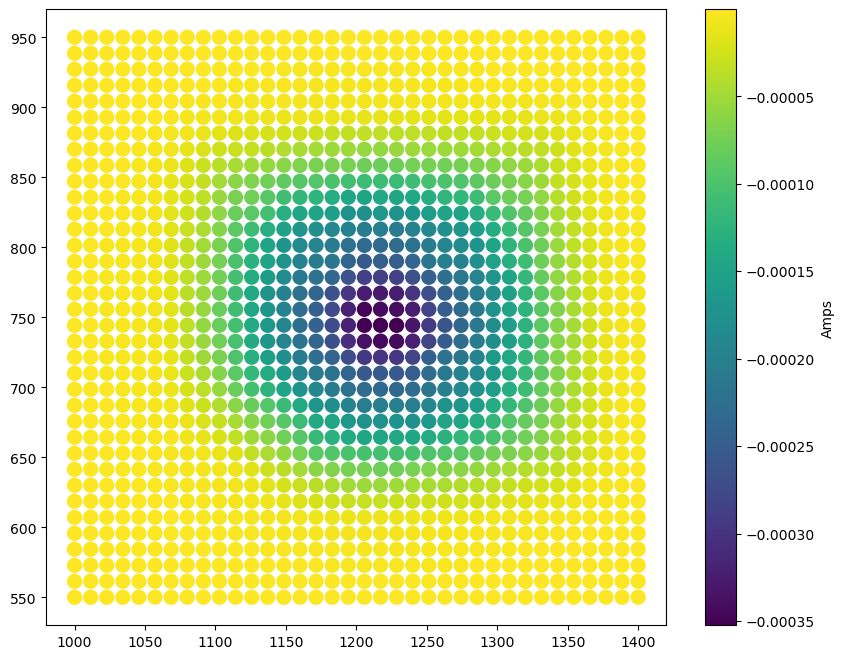

In [150]:
plt.figure(figsize=(10,8))
plt.scatter(elec_2.X,elec_2.Y, c=elec_2.MEAN, s=100)
plt.colorbar(label='Amps')
# plt.xlim(1050, 1400)
# plt.ylim(550, 900)
#plt.title(filen)

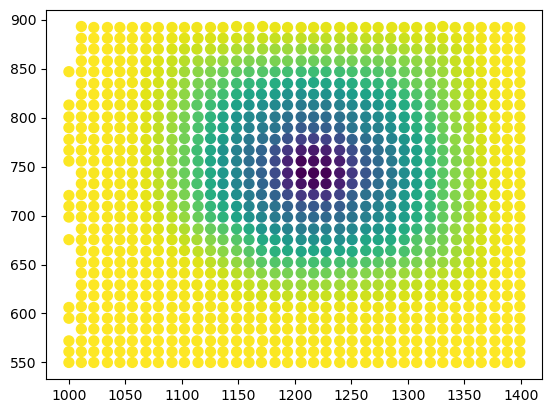

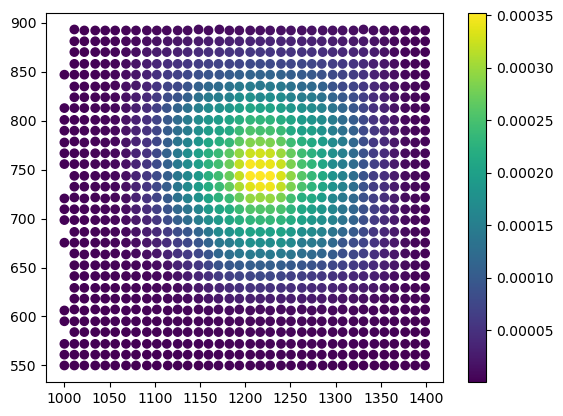

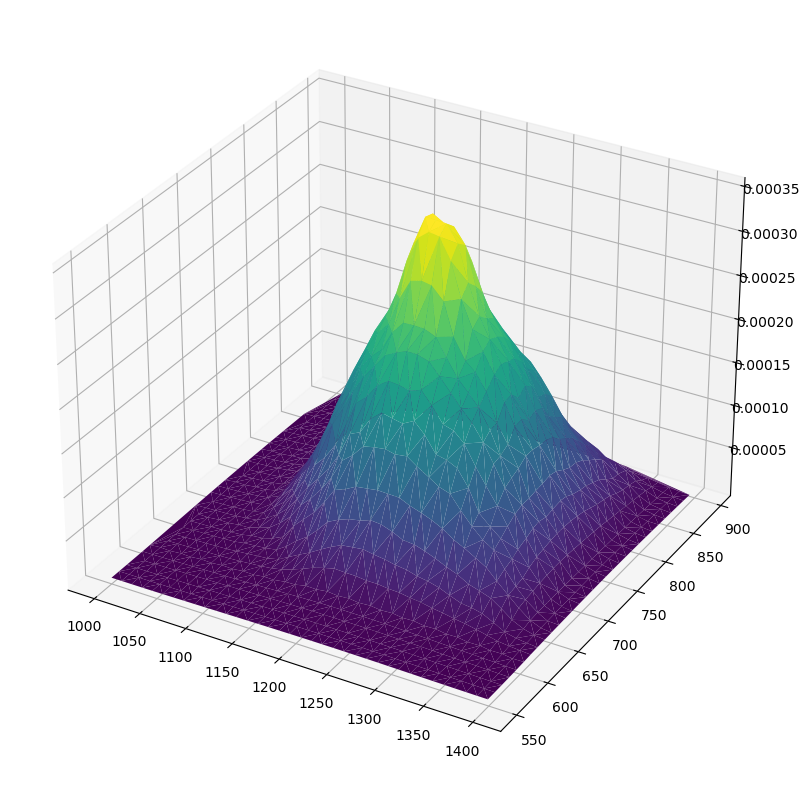

In [151]:
x = elec_2.X
y = elec_2.Y
z = elec_2.MEAN

#f = interpolate.interp2d(x, y, z, kind='linear', bounds_error=False, fill_value=np.nan)
binx = np.linspace(1000, 1400, (1400-1000))
biny = np.linspace(550, 900, (900-550))
val,xedge,yedge,binn = stats.binned_statistic_2d(x, y, z, 'mean', bins=[binx, biny])
zes = val.T
xx,yy = np.meshgrid(xedge[:-1],yedge[:-1])
plt.figure()        
plt.scatter(xx,yy,c=val.T,s=50)

X = xx.flatten()
Y = yy.flatten()
Z = zes.flatten()*-1

X = X[~np.isnan(Z)]
Y = Y[~np.isnan(Z)]
Z = Z[~np.isnan(Z)]
plt.figure()
plt.scatter(X,Y,c=Z)
plt.colorbar()

plt.figure(figsize=(10,10))
ax = plt.axes(projection = '3d')
ax.plot_trisurf(X, Y, Z,cmap = 'viridis')

Text(0, 0.5, 'Y (mm)')

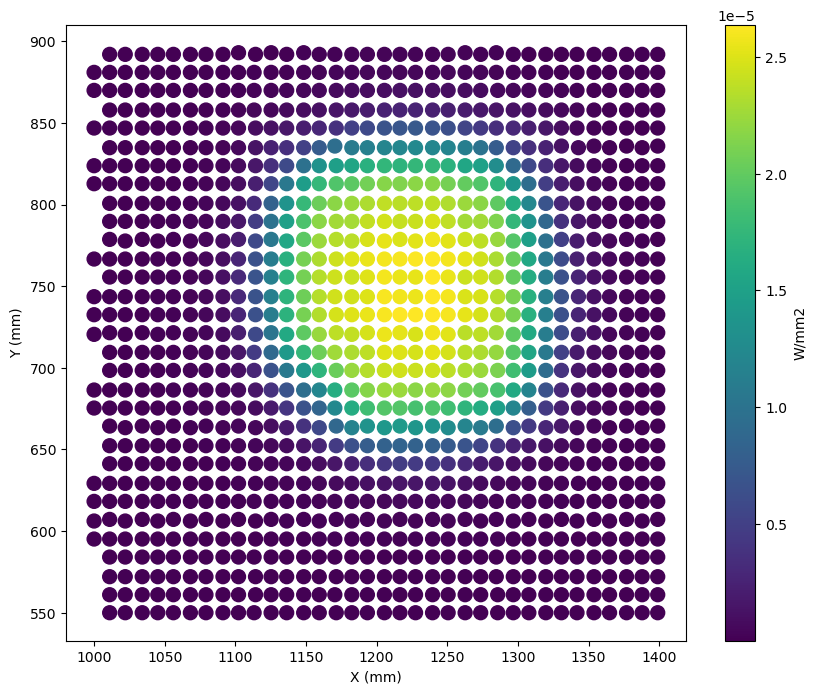

In [146]:
ZZ = watts_per_mm2(Z, 455)
plt.figure(figsize=(10,8))

plt.scatter(X, Y, c=ZZ, s=100)
plt.colorbar(label='W/mm2')
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")

Text(0, 0.5, 'W/mm2')

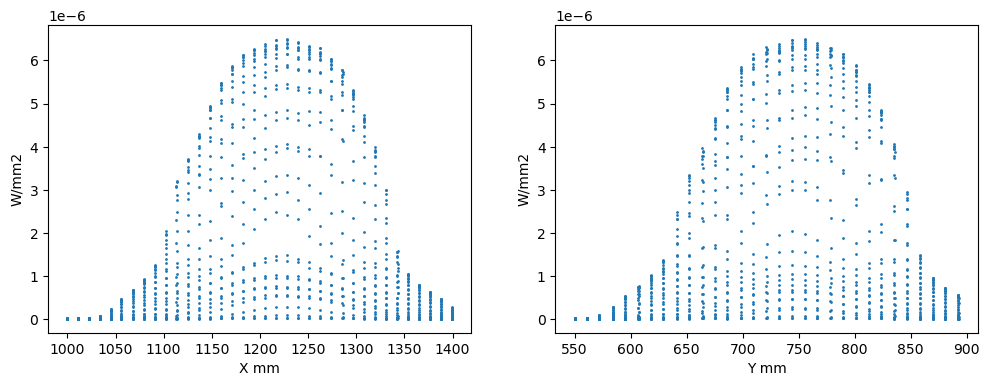

In [98]:
ZZ = watts_per_mm2(Z, 730)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.scatter(X, ZZ,s=1)
ax1.set_xlabel('X mm')
ax1.set_ylabel('W/mm2')

ax2.scatter(Y, ZZ,s=1)
ax2.set_xlabel('Y mm')
ax2.set_ylabel('W/mm2')

# ret = ax2.hist(ZZ,bins=20, label='{:.2e} ({:.2e})'.format(np.nanmean(ZZ), np.nanstd(ZZ)))
# ax2.set_xlabel('W/mm2')
# plt.legend()

Text(0, 0.5, 'W/mm2')

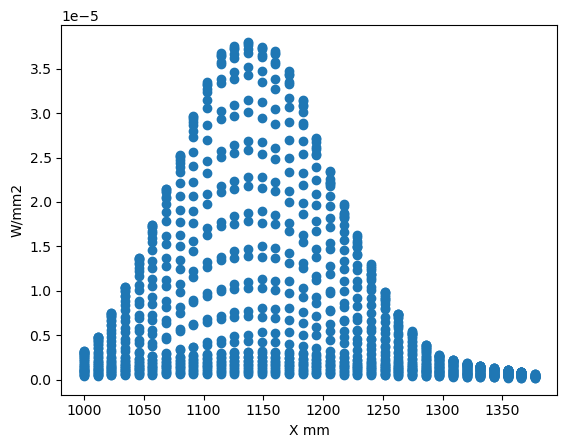

In [16]:
X = elec_2.X.flatten()
Z = elec_2.MEAN.flatten()*-1
ZZ = watts_per_mm2(Z, 455)
#fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
plt.scatter(X, ZZ)
plt.xlabel('X mm')
plt.ylabel('W/mm2')

# ax2.scatter(Y, ZZ,s=1)
# ax2.set_xlabel('Y mm')
# ax2.set_ylabel('W/mm2')

# ret = ax2.hist(ZZ,bins=20, label='{:.2e} ({:.2e})'.format(np.nanmean(ZZ), np.nanstd(ZZ)))
# ax2.set_xlabel('W/mm2')
# plt.legend()

In [24]:
import scipy.optimize as opt

def twoD_Gaussian(xy, xo, yo, sigma_x, sigma_y, amplitude, offset):
    #Function to fit, returns 2D gaussian function as 1D array
    x = xy[0]
    y = xy[1]   
    g = offset + amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()


def twoD_Moffat(xy, xo, yo, alpha, gamma, beta, offset):
    x = xy[0]
    y = xy[1] 
    g = offset + alpha * (1+(((x-xo)**2+(y-yo)**2)/gamma**2))**(-beta)
    return g

def twoD_Lorentz(xy, xo, yo, alpha, sigma):
    x = xy[0]
    y = xy[1] 
    g = alpha/np.pi * (sigma/(((x-xo)**2+(y-yo)**2)+sigma**2))
    return g

In [25]:
def oneD_Gaussian(x, xo, sigma_x, amplitude, offset):
    g = offset + amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2)))
    return g

def oneD_Moffat(x, xo, alpha, gamma, beta, offset):
    g = offset + alpha * (1+(((x-xo)**2)/gamma**2))**(-beta)
    return g

def oneD_Lorentz(x, xo, alpha, sigma):
    g = alpha/np.pi * (sigma/(((x-xo)**2)+sigma**2))
    return g

In [26]:
#730nm?
initial_guess = (1125, 725, 100, 100, 5e-5, 0)

xy = [X.ravel(), Y.ravel()]

popt, pcov = opt.curve_fit(twoD_Gaussian, xy, ZZ/np.max(ZZ), p0 = initial_guess)
print(popt)

[ 1.14014247e+03  7.19440475e+02  6.62305915e+01 -6.39766239e+01
  1.02686371e+00  1.61988842e-02]


In [15]:
#455?
initial_guess = (1140, 720, 5e-5,100, 1, 1e-2)

xy = [X.ravel(), Y.ravel()]

poptm, pcovm = opt.curve_fit(twoD_Moffat, xy, ZZ/np.max(ZZ), p0 = initial_guess)
print(poptm)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [20]:
initial_guess = (1125, 725, 1, 100)

xy = [X.ravel(), Y.ravel()]

poptl, pcovl = opt.curve_fit(twoD_Lorentz, xy, ZZ/np.max(ZZ), p0 = initial_guess)
print(poptl)

[1138.58488231  719.47228226  221.12433554   56.28598574]


In [58]:
Z

array([3.41184e-05, 3.98732e-05, 4.75857e-05, 5.68064e-05, 6.74765e-05,
       9.00215e-05, 1.43916e-04, 2.07234e-04, 2.77590e-04, 3.56104e-04,
       4.41975e-04, 5.30984e-04, 6.21569e-04, 7.14793e-04, 7.94605e-04,
       8.33782e-04, 8.42833e-04, 8.39086e-04, 8.28556e-04, 7.95005e-04,
       7.32722e-04, 6.40664e-04, 5.43315e-04, 4.56417e-04, 3.79644e-04,
       3.06676e-04, 2.40030e-04, 1.82677e-04, 1.37230e-04, 1.00356e-04,
       7.02756e-05, 5.29617e-05, 4.38607e-05, 3.66984e-05, 3.08387e-05,
               nan])

In [97]:
initial_guess = (1125, 100, 5e-5, 0)
idx = np.isnan(ZZ)
X = X[~idx]
ZZ = ZZ[~idx]
popt, pcov = opt.curve_fit(oneD_Gaussian, X, ZZ/np.max(ZZ), p0 = initial_guess)
print(popt)

[ 1.14408414e+03 -6.42695412e+01  9.17007554e-01  4.50149851e-02]


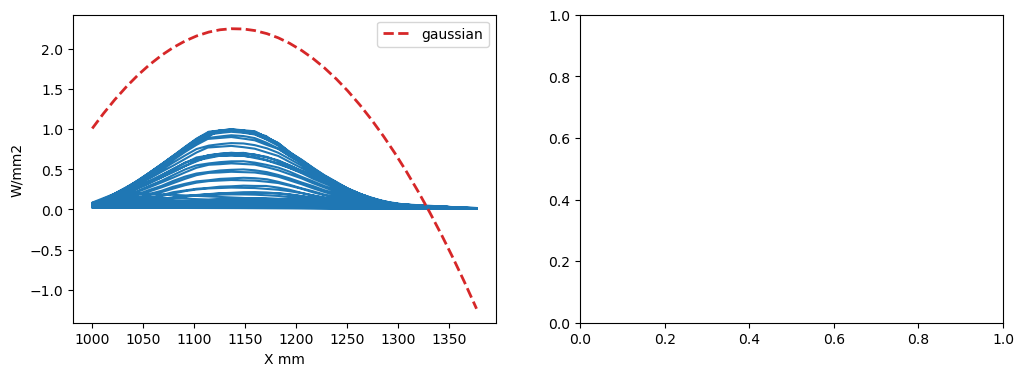

In [27]:
#ZZ = watts_per_mm2(Z, 730)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.plot(X, ZZ/np.max(ZZ))
ax1.plot(np.sort(X), oneD_Gaussian(np.sort(X), popt[0], popt[1], popt[2], popt[3]), '--',c='C3',linewidth=2,label='gaussian') 
#ax1.plot(np.sort(X), oneD_Moffat(np.sort(X), poptm[0], poptm[2], poptm[3], poptm[4], poptm[5]), '--',c='C1',linewidth=2,label='moffat') 
#ax1.plot(np.sort(X), oneD_Lorentz(np.sort(X), poptl[0], poptl[2], poptl[3]), '--',linewidth=2,c='C2',label='lorentzian') 
ax1.set_xlabel('X mm')
ax1.set_ylabel('W/mm2')
ax1.legend()

# ax2.scatter(Y, ZZ/np.max(ZZ),s=1)
# ax2.plot(Y, oneD_Gaussian(Y, popt[1], popt[3], popt[4], popt[5]), '--',c='C3',linewidth=2,label='gaussian') 
# #ax2.plot(Y, oneD_Moffat(Y, poptm[1], poptm[2], poptm[3], poptm[4], poptm[5]), '--',c='C1',linewidth=2,label='moffat') 
# ax2.plot(Y, oneD_Lorentz(Y, poptl[1], poptl[2], poptl[3]), '--',linewidth=2,c='C2',label='lorentzian') 
# ax2.set_xlabel('Y mm')
# ax2.set_ylabel('W/mm2')
# ax2.legend()

In [27]:
x_ = np.tan(np.deg2rad(40))*103.3
x_1 = np.tan(np.deg2rad(50))*103.3
x_2 = np.tan(np.deg2rad(30))*103.3

In [29]:
dist = 91 #mm
def angle_output(x):
    return np.rad2deg(np.arctan(x/dist))

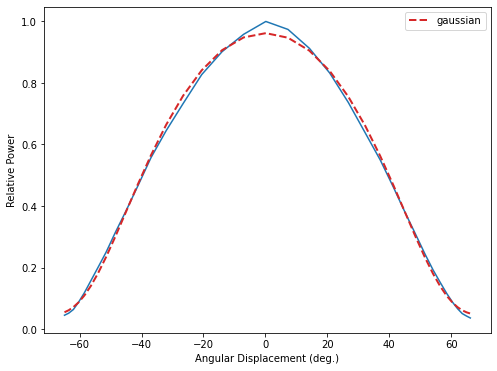

In [100]:
fig, ax1 = plt.subplots(1, figsize=(8,6))
ax1.plot(angle_output(X-popt[0]), ZZ/np.max(ZZ))
ax1.plot(angle_output(X-popt[0]), oneD_Gaussian(X, popt[0], popt[1], popt[2], popt[3]), '--',c='C3',linewidth=2,label='gaussian') 
#ax1.plot(angle_output(Y-popt[1]), oneD_Moffat(Y, poptm[1], poptm[2], poptm[3], poptm[4], poptm[5]), '--',c='C1',linewidth=2,label='moffat') 
#ax1.plot(angle_output(Y-popt[1]), oneD_Lorentz(Y, poptl[1], poptl[2], poptl[3]), '--',linewidth=2,c='C2',label='lorentzian') 


# plt.axvline(popt[1]+x_, label='40deg',c='k')
# plt.axvline(popt[1]-x_,c='k')
# plt.axvline(popt[1]+x_1, label='50deg',c='r')
# plt.axvline(popt[1]-x_1,c='r')
# plt.axvline(popt[1]+x_2, label='30deg',c='g')
# plt.axvline(popt[1]-x_2,c='g')
ax1.set_xlabel('Angular Displacement (deg.)')
ax1.set_ylabel('Relative Power')
#plt.xlim(0,90)
ax1.legend()

In [25]:
df = pd.read_csv('plot-data.csv')
df1 = pd.read_csv('plot-data_L3.csv')
df2 = pd.read_csv('plot-data-730.csv')

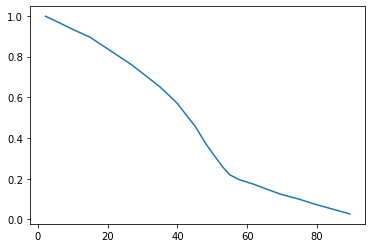

In [38]:
df2.sort_values(by='x',inplace=True)
plt.plot(df2.x, df2[' y'])

Text(0.5, 1.0, 'Output of M455L3 at ~90mm')

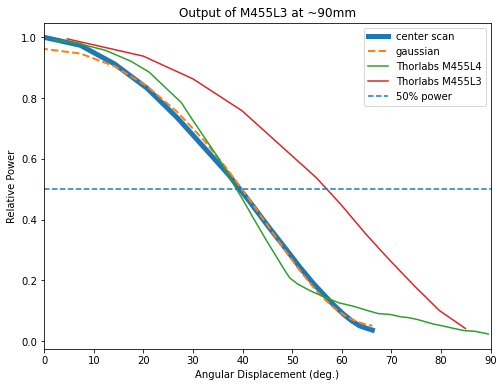

In [102]:
fig, ax1 = plt.subplots(1, figsize=(8,6))
ax1.plot(angle_output(X-popt[0]), ZZ/np.max(ZZ), linewidth=5, label='center scan')
ax1.plot(angle_output(X-popt[0]), oneD_Gaussian(X, popt[0], popt[1], popt[2], popt[3]), '--',linewidth=2,label='gaussian') 
#ax1.plot(angle_output(Y-popt[1]), oneD_Moffat(Y, poptm[1], poptm[2], poptm[3], poptm[4], poptm[5]), '--',c='C1',linewidth=2,label='moffat') 
#ax1.plot(angle_output(Y-popt[1]), oneD_Lorentz(Y, poptl[1], poptl[2], poptl[3]), '--',linewidth=2,c='C2',label='lorentzian') 

ax1.plot(df.x, df[' y'], c='C2', label='Thorlabs M455L4')
ax1.plot(df1.x, df1[' y'], c='C3',label='Thorlabs M455L3')
#ax1.plot(df2.x, df2[' y'],label='Thorlabs M730L5')
ax1.axhline(0.5,ls='--',label='50% power')
#ax1.axhline(
# plt.axvline(popt[1]+x_, label='40deg',c='k')
# plt.axvline(popt[1]-x_,c='k')
# plt.axvline(popt[1]+x_1, label='50deg',c='r')
# plt.axvline(popt[1]-x_1,c='r')
# plt.axvline(popt[1]+x_2, label='30deg',c='g')
# plt.axvline(popt[1]-x_2,c='g')
ax1.set_xlabel('Angular Displacement (deg.)')
ax1.set_ylabel('Relative Power')
plt.xlim(0,90)
ax1.legend()
ax1.set_title('Output of M455L3 at ~90mm')

NameError: name 'df2' is not defined

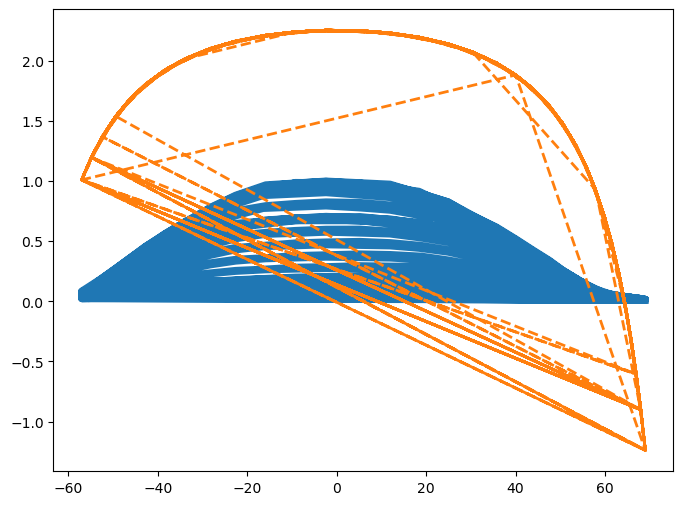

In [30]:
fig, ax1 = plt.subplots(1, figsize=(8,6))
ax1.plot(angle_output(X-popt[0]), ZZ/np.max(ZZ), linewidth=5, label='center scan')
ax1.plot(angle_output(X-popt[0]), oneD_Gaussian(X, popt[0], popt[1], popt[2], popt[3]), '--',linewidth=2,label='gaussian') 
#ax1.plot(angle_output(Y-popt[1]), oneD_Moffat(Y, poptm[1], poptm[2], poptm[3], poptm[4], poptm[5]), '--',c='C1',linewidth=2,label='moffat') 
#ax1.plot(angle_output(Y-popt[1]), oneD_Lorentz(Y, poptl[1], poptl[2], poptl[3]), '--',linewidth=2,c='C2',label='lorentzian') 

#ax1.plot(df.x, df[' y'], c='C2', label='Thorlabs M455L4')
#ax1.plot(df1.x, df1[' y'], c='C3',label='Thorlabs M455L3')
ax1.plot(df2.x, df2[' y'],label='Thorlabs M730L5')
ax1.axhline(0.5,ls='--',label='50% power')
#ax1.axhline(
# plt.axvline(popt[1]+x_, label='40deg',c='k')
# plt.axvline(popt[1]-x_,c='k')
# plt.axvline(popt[1]+x_1, label='50deg',c='r')
# plt.axvline(popt[1]-x_1,c='r')
# plt.axvline(popt[1]+x_2, label='30deg',c='g')
# plt.axvline(popt[1]-x_2,c='g')
ax1.set_xlabel('Angular Displacement (deg.)')
ax1.set_ylabel('Relative Power')
plt.xlim(0,90)
ax1.legend()
ax1.set_title('Output of M730L5 at ~90mm')

## Collimator Only Scans

In [4]:

hdu.info()

Filename: /home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-08-31T23:33:02.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  2             1 BinTableHDU     27   1296R x 9C   [D, D, D, D, D, D, D, D, D]   


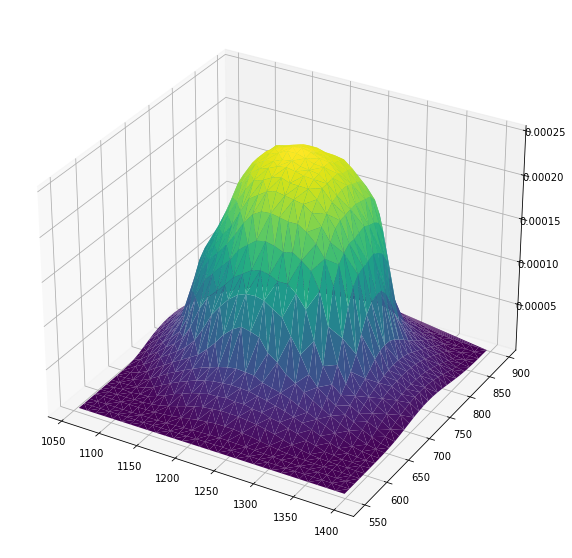

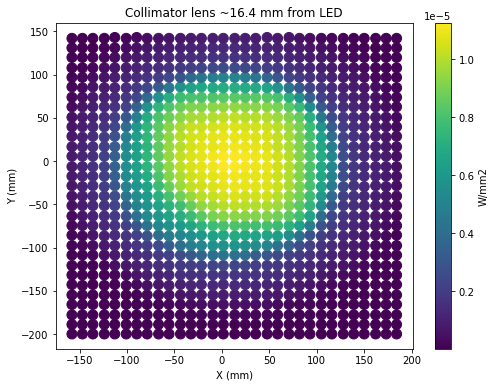

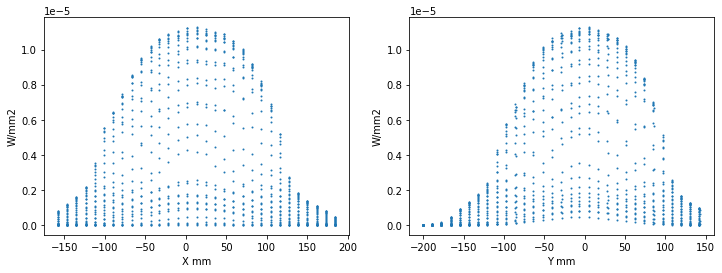

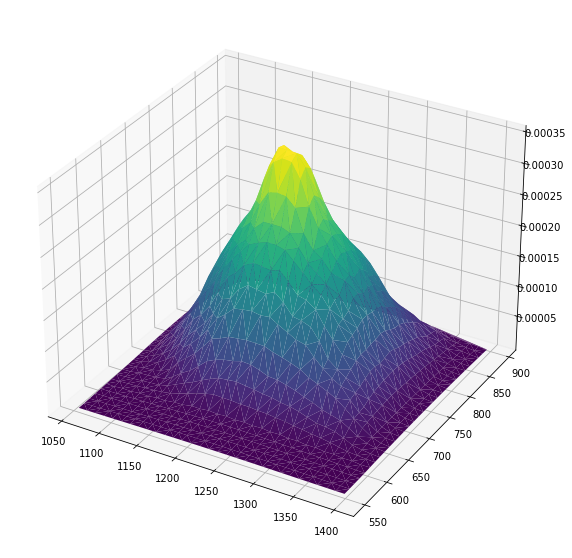

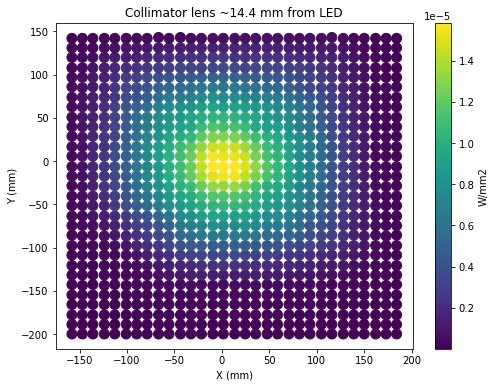

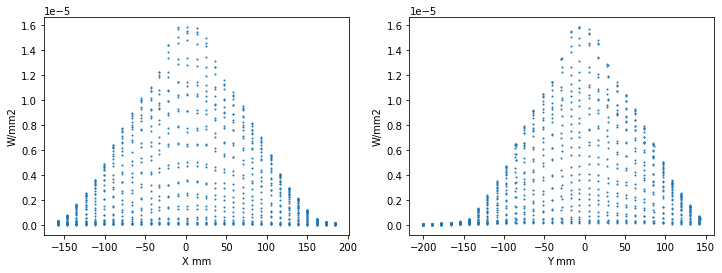

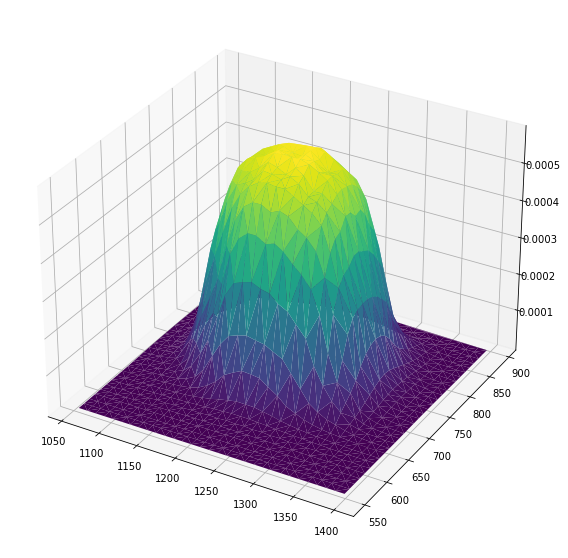

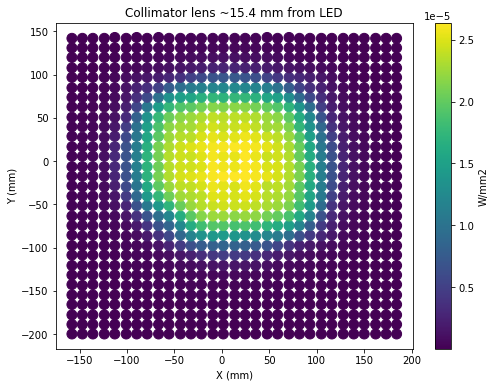

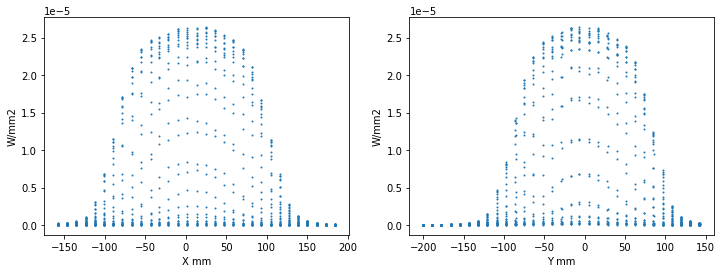

In [37]:
for i, dist in enumerate([16.4, 14.4, 15.4]):
    hdu = fits.open(scan_files[(i+1)*-1])
    elec_2 = hdu['2'].data
    x = elec_2.X
    y = elec_2.Y
    z = elec_2.MEAN

    #f = interpolate.interp2d(x, y, z, kind='linear', bounds_error=False, fill_value=np.nan)
    binx = np.linspace(1050, 1400, (1400-1050))
    biny = np.linspace(550, 900, (900-550))
    val,xedge,yedge,binn = stats.binned_statistic_2d(x, y, z, 'mean', bins=[binx, biny])
    zes = val.T
    xx,yy = np.meshgrid(xedge[:-1],yedge[:-1])
    # plt.figure()        
    # plt.scatter(xx,yy,c=val.T,s=50)

    X = xx.flatten()
    Y = yy.flatten()
    Z = zes.flatten()*-1

    X = X[~np.isnan(Z)]
    Y = Y[~np.isnan(Z)]
    Z = Z[~np.isnan(Z)]
    # plt.figure()
    # plt.scatter(X,Y,c=Z)
    # plt.colorbar()

    plt.figure(figsize=(10,10))
    ax = plt.axes(projection = '3d')
    ax.plot_trisurf(X, Y, Z,cmap = 'viridis')

    ZZ = watts_per_mm2(Z, 455)
    plt.figure(figsize=(8,6))

    plt.scatter(X-1215, Y-750, c=ZZ, s=100)
    plt.colorbar(label='W/mm2')
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.title('Collimator lens ~{} mm from LED'.format(dist))

    ZZ = watts_per_mm2(Z, 455)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
    ax1.scatter(X-1215, ZZ,s=1)
    ax1.set_xlabel('X mm')
    ax1.set_ylabel('W/mm2')

    ax2.scatter(Y-750, ZZ,s=1)
    ax2.set_xlabel('Y mm')
    ax2.set_ylabel('W/mm2')